In [4]:
#Inital Imports
import numpy as np
import networkx as nx
import pandas as pd
import gurobipy as gb
import matplotlib.pyplot as plt
import time
import random

from gurobipy import GRB

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

## Step 1: Parse Network Topology and load Demands

In [5]:
# load data fram using pandas for topology
df = pd.read_csv("data/Sprint/topology.txt", delimiter=r"\s+")

# Create Graph

G = nx.from_pandas_edgelist(df, 'from_node', 'to_node', ['capacity', 'prob_failure'])

#load demands 

demands = np.loadtxt("data/Sprint/demand.txt")

## Step 2: Visualize Graph

{(10, 9): Text(0.920626759959206, 0.27032038693904664, '1000000000'),
 (10, 1): Text(0.42884249549647624, -0.49491071161947087, '1000000000'),
 (10, 7): Text(0.020253514591924093, 0.14086629644921533, '1000000000'),
 (10, 6): Text(0.707707555685761, -0.45481597859850814, '1000000000'),
 (10, 4): Text(0.42884258490344296, 0.4949107170380748, '1000000000'),
 (9, 8): Text(0.6283343007438058, 0.7251363682468568, '1000000000'),
 (9, 4): Text(0.3494693448626489, 0.7652311012678195, '1000000000'),
 (8, 3): Text(-0.11972279239934794, 0.8326908033940423, '1000000000'),
 (8, 7): Text(-0.272038944623476, 0.5956822777570254, '1000000000'),
 (8, 4): Text(0.1365501256880428, 0.949726698345885, '1000000000'),
 (4, 3): Text(-0.3985877482805049, 0.872785536415005, '1000000000'),
 (4, 0): Text(-0.550903900504633, 0.35404443819932263, '1000000000'),
 (4, 5): Text(0.34946931506032664, 0.2245902732036857, '1000000000'),
 (7, 0): Text(-0.9594929708161518, 1.76104631710583e-08, '1000000000'),
 (7, 6): Text(-

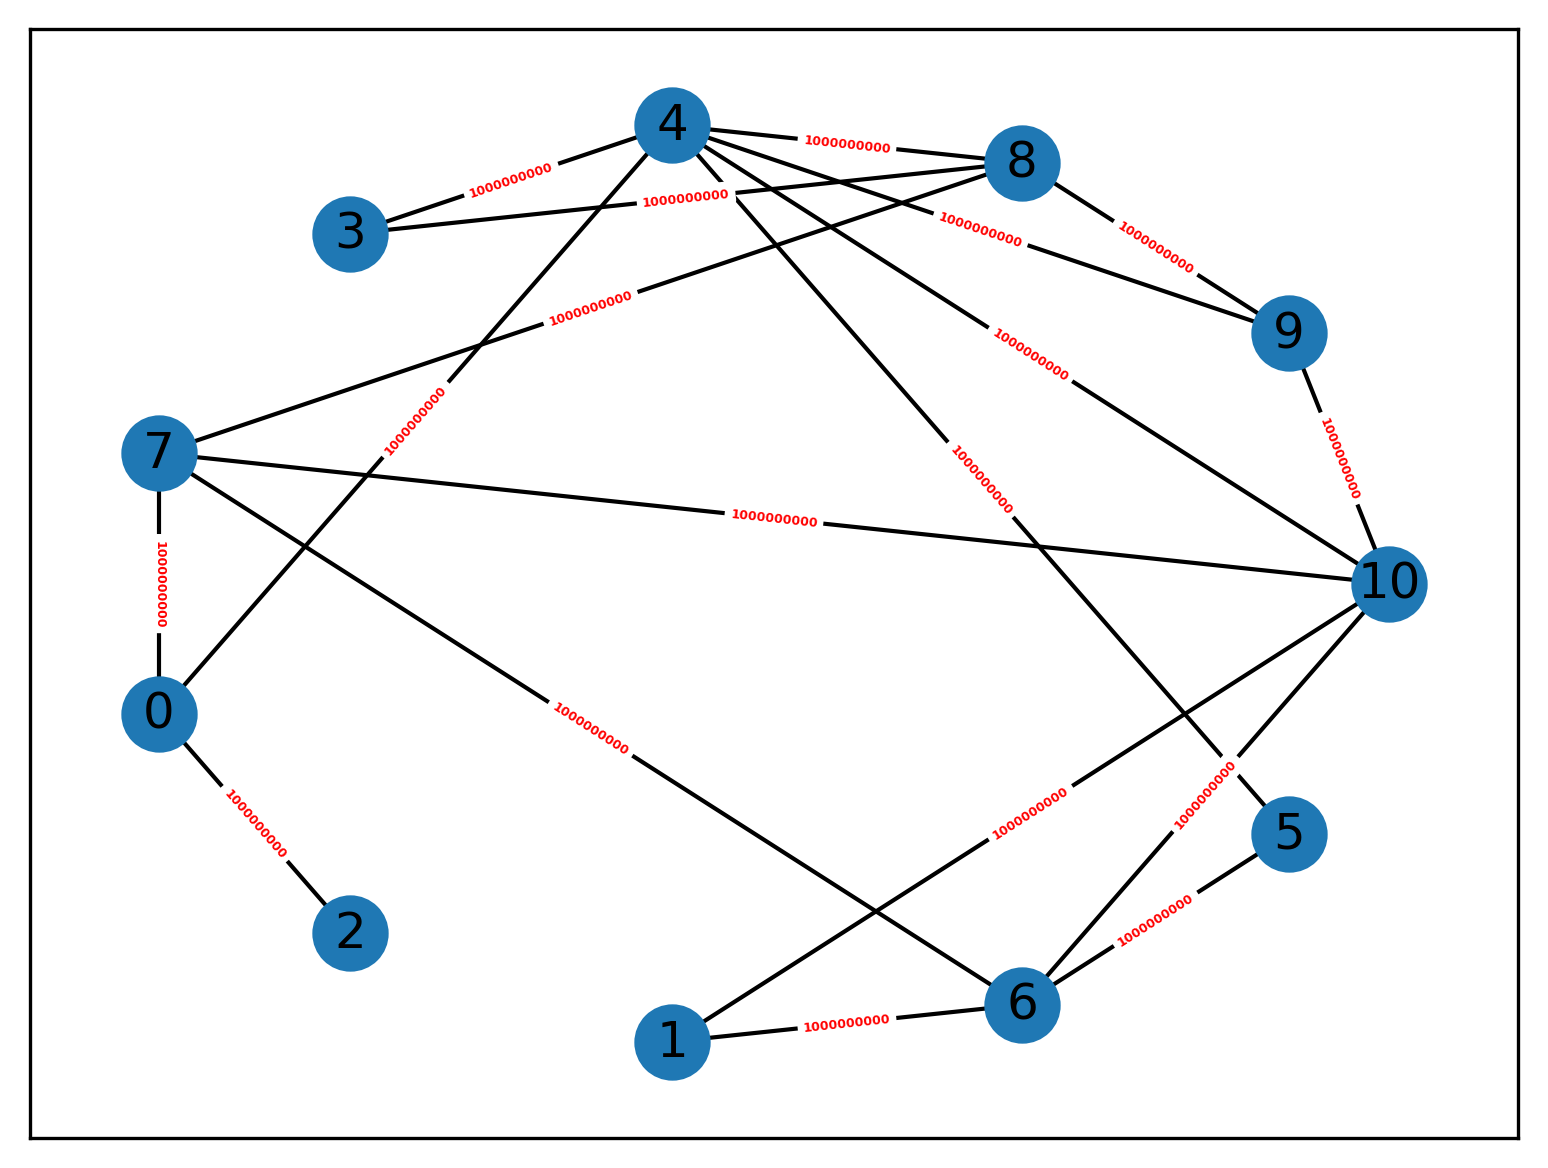

In [6]:
#Draw loaded graph
# spring layout prevents graph from
# becoming too clustered
layout = nx.circular_layout(G)
# draw node, edges, and labels sperately
nx.draw_networkx_labels(G, pos=layout)
nx.draw_networkx_nodes(G, pos=layout)
nx.draw_networkx_edges(G, pos=layout)
# only add capacities as labels
edge_labels = dict([((source, dest), G[source][dest]["capacity"]) for source, dest in G.edges])
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels= edge_labels,font_color="red", font_weight="bold", font_size = 3)

In [7]:
## Get paths
## for each node, find paths to destination node
## paths[(i,j)] = list of paths specified by edges

## parameter G - input graph
def get_paths(G):
    paths = {}

    num_paths = {}

    n=len(G.nodes)

    for i in range(0,n):
        for j in range(0,n):
            path_gen = nx.all_simple_edge_paths(G, source=i, target=j, cutoff=5)
            p = list(path_gen)
            num_paths[(i,j)] = len(p)
            for k in range(len(p)):
                paths[(i,j,k)] = p[k]

    #print(paths[1,2,0])
    return paths

paths = get_paths(G)


## Step 3: Parse Traffic Demands

In [8]:

## get the maximum value for each column
## reshape demands matrix
demands_matrix = np.amax(demands, axis = 0).reshape(11,11)

demands_dict = {}
for i in range(11):
    for j in range(11):
        demands_dict[(i,j)] = demands[i][j]

## Step 4: Traffic Algorithm: Maximize Total Throughput


Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-18
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 139 rows, 1734 columns and 8942 nonzeros
Model fingerprint: 0xfedc8505
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+03, 1e+09]
Presolve removed 139 rows and 1734 columns
Presolve time: 0.02s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.2145631e+06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds (0.00 work units)
Optimal objective  4.214563058e+06
[(10, 4, {'weight': 3370679.0}), (4, 5, {'weight': 1474895.0}), (6, 5, {'weight': 1414110.0}), (10, 6, {'weig

0.03499627113342285

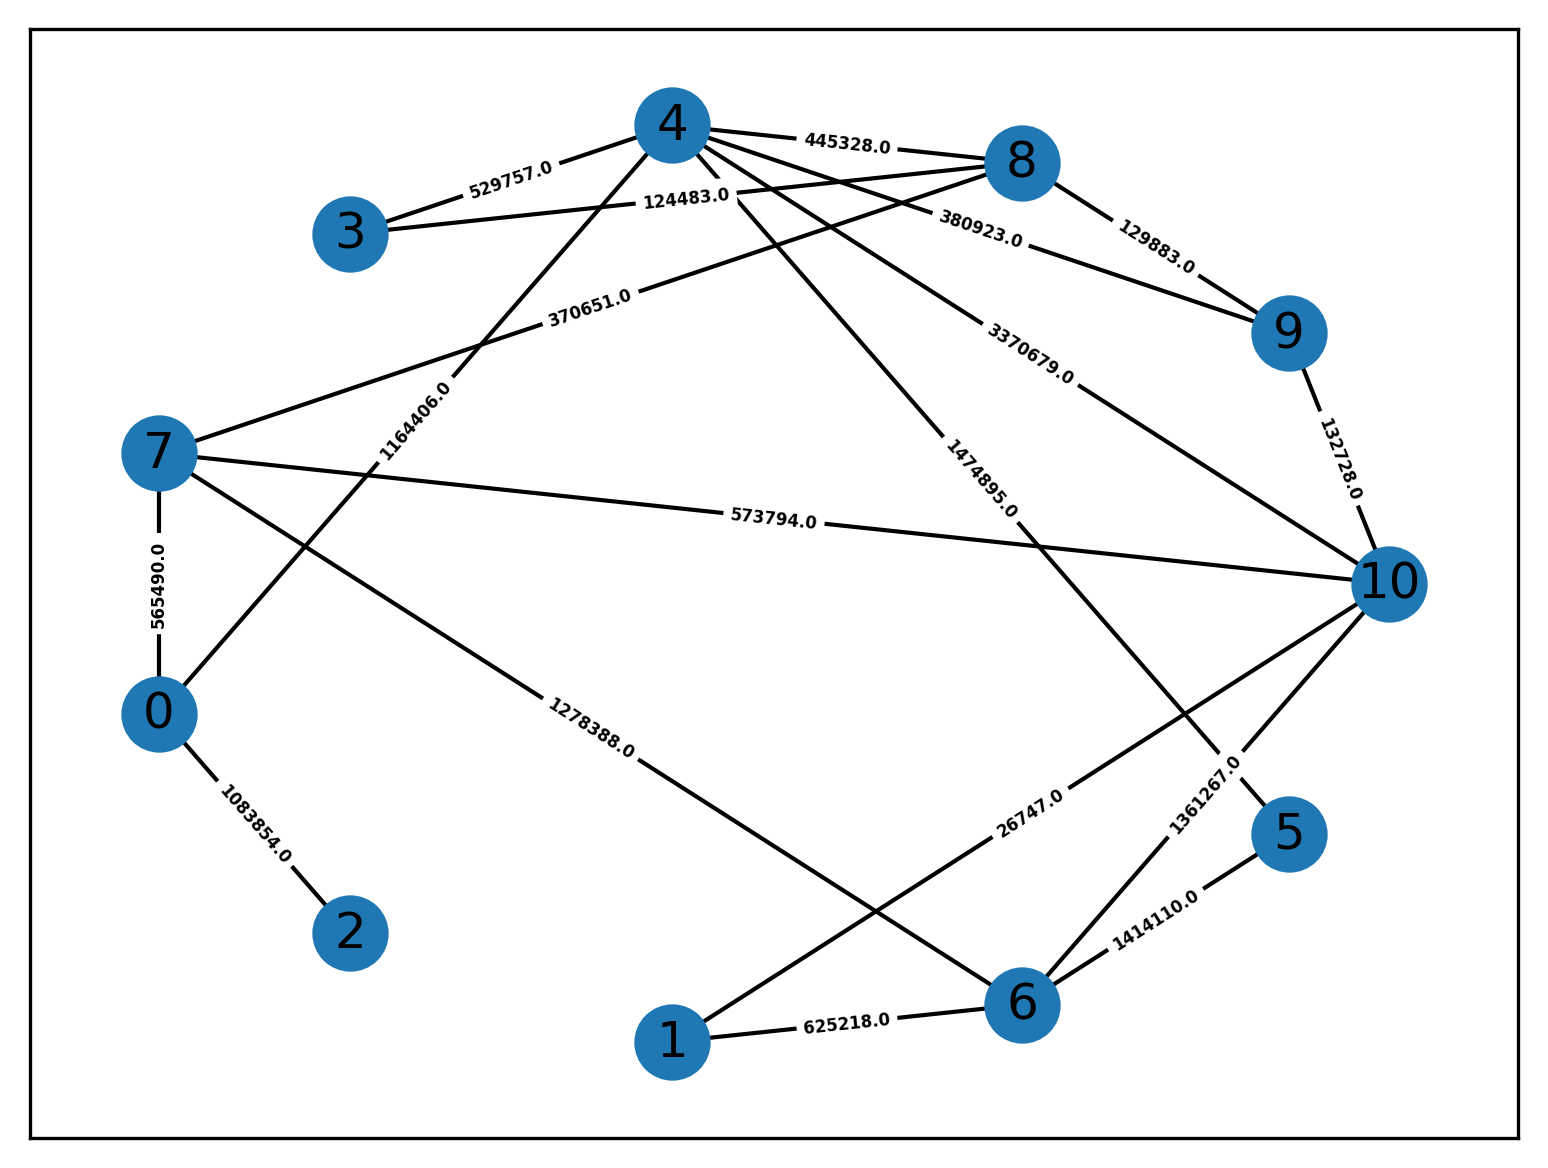

In [9]:
# function to build compute edge flows
# 
#
# parameter G - Input Graph
# parameter paths - paths within the graph
# demand_dict - dictionary of demands
# display -display chart

# returns time to optimize


def maximize_throughput(G, paths, demands_dict, display=False):


    # new model
    m = gb.Model("step4")

    # add a variable for each tunnel
    path_vars = m.addVars(paths, name = "path_flow")

    # dictionary mapping edges to variables representing paths edge is in
    edge_flow = gb.tupledict([((source, dest), []) for source, dest in G.edges])

    edge_labels = dict([((source, dest), G[source][dest]["capacity"]) for source, dest in G.edges])


    # iterate through all paths
    for (i,j,k) in path_vars:
        path = paths[(i,j,k)]
        # iterate each edge in a path
        for src,dest in path:
            # add variable to correct edge
            if (src,dest) in edge_flow:
                edge_flow[(src,dest)].append(path_vars[i,j,k])
            else:
                edge_flow[(dest,src)].append(path_vars[i,j,k])

    # add capacity constraint
    for i,j in edge_flow:
        m.addConstr(sum(edge_flow[(i,j)]) <= edge_labels[(i,j)])
    #add demand constraint
    m.addConstrs(path_vars.sum(i,j,'*') <= demands_dict[(i,j)] for i,j in demands_dict)

    m.setObjective(path_vars.sum(), GRB.MAXIMIZE)
    
    #time the optimization
    start_time = time.time() 
    m.optimize()
    end_time = time.time()

    path_vars

    G_Prime = nx.Graph()

    #get edge flows
    for path_key in path_vars:
        path = paths[path_key]
        val = round(path_vars[path_key].X,0)
        for (src, dest) in path:
            if G_Prime.has_edge(src, dest):
                G_Prime[src][dest]['weight'] += val
            else:
                G_Prime.add_edge(src, dest, weight = val)
        
    GPrime_labels = nx.get_edge_attributes(G_Prime, "weight")


    if(display):
        # draw node, edges, and labels sperately
        nx.draw_networkx_labels(G_Prime, pos=layout)
        nx.draw_networkx_nodes(G_Prime, pos=layout)
        nx.draw_networkx_edges(G_Prime, pos=layout)
        # only add flows as labels
        edge_labels = dict([((source, dest), G[source][dest]["capacity"]) for source, dest in G.edges])
        nx.draw_networkx_edge_labels(G_Prime, pos=layout, edge_labels= GPrime_labels, font_weight="bold", font_size = 4)
        print(sorted(G_Prime.edges(data=True),key= lambda x: x[2]['weight'],reverse=True))

    #return time to optimize

    return end_time - start_time

maximize_throughput(G, paths, demands_dict, True)


## Step 5: Traffic Algorithm: Maximize Link Utilization

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 157 rows, 1735 columns and 16168 nonzeros
Model fingerprint: 0xe3bc2d56
Variable types: 1735 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e-09, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+03, 1e+09]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 1 objectives ... 
---------------------------------------------------------------------------
---------------------------------------------------------------------------

Multi-objectives: optimize objective 1 () ...
---------------------------------------------------------------------------

Optimize a model with 157 rows, 1735 columns and 16168

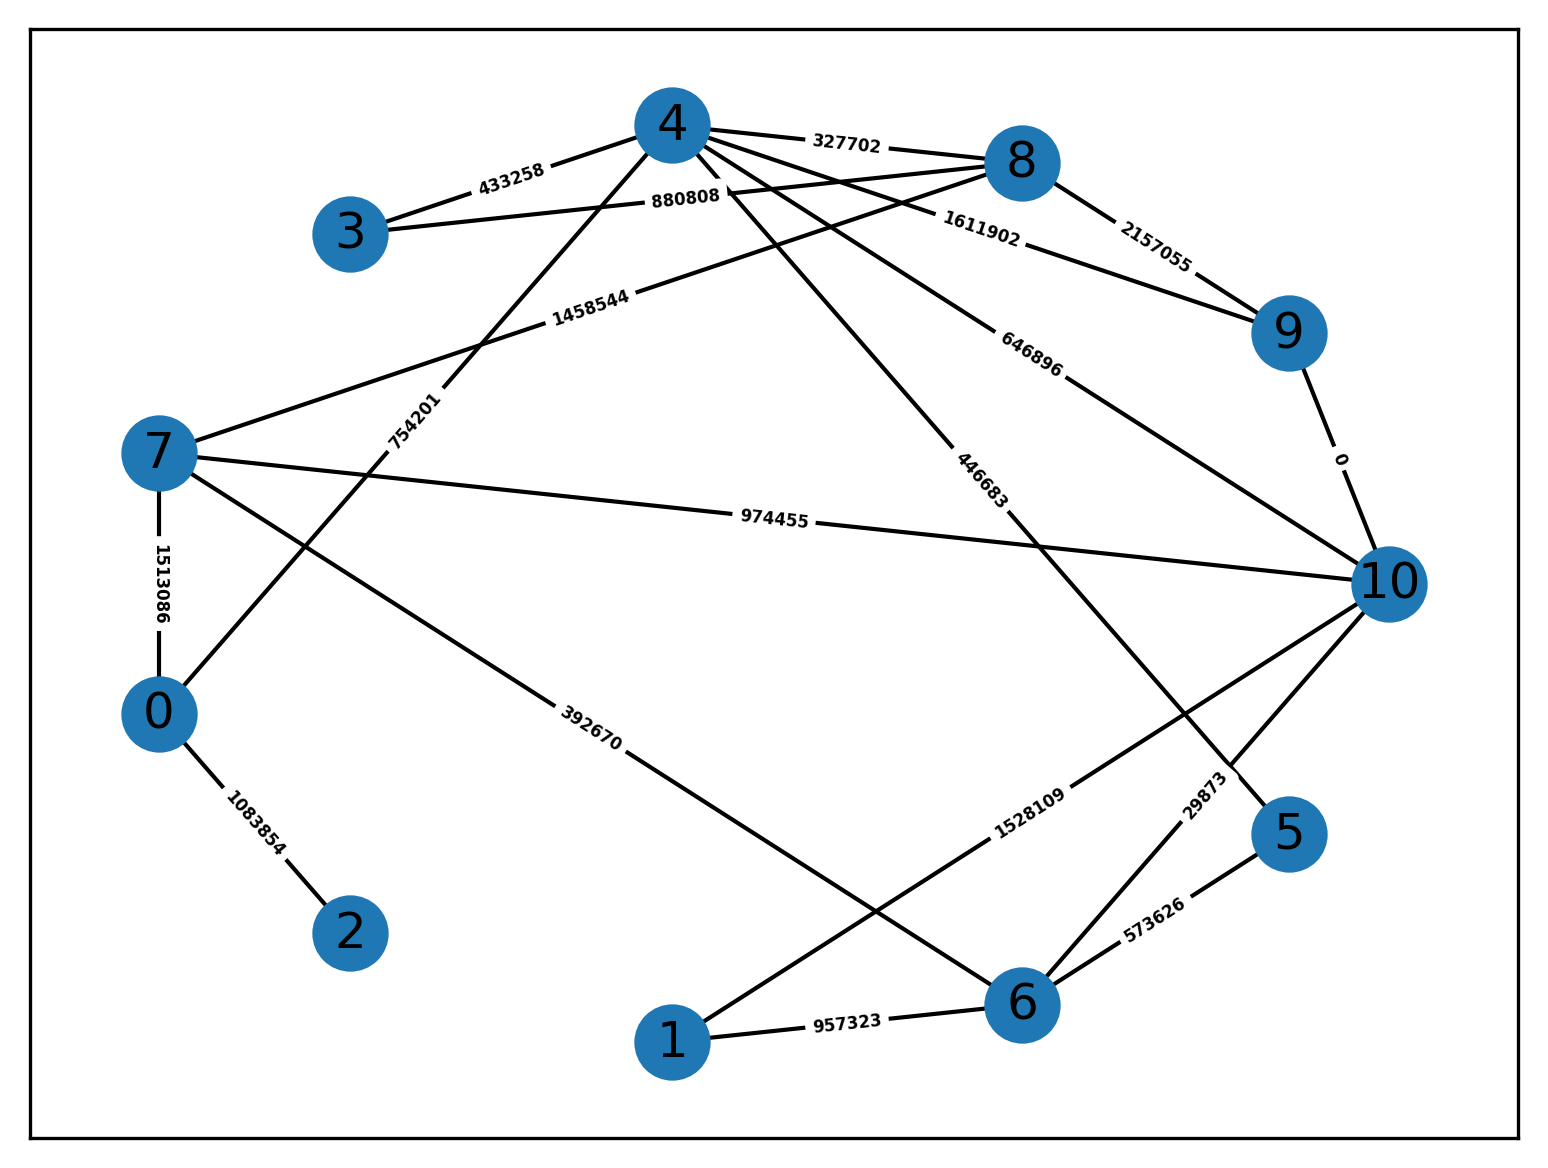

In [11]:
#Same as step 4 on a new model

# function to build minimize MLU while still having strong
# throughput
#
# parameter G - Input Graph
# parameter paths - paths within the graph
# demand_dict - dictionary of demands
# display -display chart

# returns time to optimize


def minimize_MLU(G, paths, demands_dict, display=False):
    m = gb.Model("step5")
    path_vars = m.addVars(paths, name = "path_flow")
    edge_flows = gb.tupledict([((source, dest), []) for source, dest in G.edges])
    edge_labels = dict([((source, dest), G[source][dest]["capacity"]) for source, dest in G.edges])

    for (i,j,k) in path_vars:
        path = paths[(i,j,k)]
        for src,dest in path:
            if (src,dest) in edge_flows:
                edge_flows[(src,dest)].append(path_vars[i,j,k])
            else:
                edge_flows[(dest,src)].append(path_vars[i,j,k])

    # add capacity constraint
    for i,j in edge_flows:
        m.addConstr(sum(edge_flows[(i,j)]) <= edge_labels[(i,j)])


    #***new for step 5*** Need to add constraint that the maximum link value needs to be reduced 

    # add variable for MLU
    MLU = m.addVar(vtype=GRB.CONTINUOUS, name="MLU")
    # add constraint that all link utilizations must be <= MLU
    for i, j in edge_flows:
        m.addConstr(sum(edge_flows[(i,j)])/edge_labels[(i,j)] <= MLU)
    # minimize MLU while encouraging meeting demands, total flow over total demand
    total_demand = np.sum(demands_matrix)
    #m_prime.setObjective(MLU - path_vars5.sum()/total_demand, GRB.MINIMIZE)

    #having demand bounded like this will push all nodes to have "0" for flow, so we want to maximize the throughput as well (which is why we reuse step 4 constraints)

    m.addConstrs(path_vars.sum(i,j,'*') <= demands_dict[(i,j)] for i,j in demands_dict)

    #primary objective

    m.setObjectiveN(MLU - path_vars.sum() , 0)

    #m_prime.setObjectiveN(path_vars5.sum(), index=1, GRB.MAXIMIZE)
    start_time = time.time()
    m.optimize()
    end_time = time.time()

    path_vars

    print(MLU)

    #Alternative written of step 4 visualization using edge_flows:
    G_Prime = nx.Graph()

    for i,j in edge_flows:
        G_Prime.add_edge(i, j, weight = round(sum(edge_flows[i,j]).getValue()))

    GPrime_labels = nx.get_edge_attributes(G_Prime, "weight")
    # draw node, edges, and labels sperately
    if(display):
        nx.draw_networkx_labels(G_Prime, pos=layout)
        nx.draw_networkx_nodes(G_Prime, pos=layout)
        nx.draw_networkx_edges(G_Prime, pos=layout)
        # only add capacities as labels
        nx.draw_networkx_edge_labels(G_Prime, pos=layout, edge_labels= GPrime_labels, font_weight="bold", font_size = 4)
        print(sorted(G_Prime.edges(data=True),key= lambda x: x[2]['weight'],reverse=True))
    
    return end_time - start_time

print(minimize_MLU(G, paths, demands_dict, True))


## Step 6: Compare Algorithms

We see that when maximizing throughput alone, there is a single edge from node 4 to node 10 that is given 3000000+ Gbps, being an outlier. For the MLU allocations, the traffic is more evenly distributed over links. This is because by minimizing the MLU, we prevent any single link from being allocated an exorbitant amount of flow.

This in turn makes minimizing the MLU more resilient to failure. With the maximize throughput allocations, there is a single link with lots of flow. If this link between nodes 10 and 4 happened to fail, it would be catastrophic with large amounts of traffic being lost and heavy re-routing would be required. However, by minimizing the MLU, we avoid this. While a link failing will still cause a large amount of traffic to be lost, it will not be nearly as bad as that single link failing in the other case. By spreading out traffic, there is less potential for a single link failure to devastate the network, making this method of flow allocation more resilient in such cases.

Note that there are some benefits of the throughput method of allocation however. Simply because we are not constrained by having to minimize the MLU, maximizing the throughput can allow for a variety of different configurations. The configurations can have more freedom in the paths that they choose to direct flow. Thus it is possible that in the case of maximizing throughput alone, shorter paths can be taken, which in turn would allow for lower latency in the network, a metric that was not optimized in this project.


## Step 7 (EXTRA CREDIT): Scaling with Topology Size

In [34]:
# Generate Random Graph and demands and optimizes it
# 
# n - number of nodes
# max_capacity - max capacity of edges
# max_demand - max demand
# p -probability
# m1 - number of edges from each node for prob p
# m2 - number of edges for each node with prob 1-p

# returns time to optimize both versions
def gen_rand_graph(n, max_capacity, max_demand, p =0.5, m1 = 3, m2 =4):
    G = nx.dual_barabasi_albert_graph(n, m1, m2, p)
    #we want a connected graph, regenerate until we get one
    while not nx.is_connected(G):
        G = nx.dual_barabasi_albert_graph(n, m1, m2, p)

    print("Graph Ready")
    #add random capacities to edges
    for (u,v,w) in G.edges(data=True):
        w['capacity'] = random.randint(1, max_capacity)

    # create random demands
    print("Creating Demands")
    demands_dict = dict()
    for i in range(n):
        for j in range(n):
            demands_dict[(i,j)] = random.randint(0, max_demand)
    print("Getting Paths")
    paths = get_paths(G)
    return G, demands_dict, paths

x_axis =list()
y_axis_max = list()
y_axis_min = list()



    

In [35]:
G1 , demands_dict1, paths1= gen_rand_graph(5, 10000000, 10000000, m1=3, m2 =4, p =0.5)
print("Maximizing")
time1 = maximize_throughput(G1, paths1, demands_dict1, False)
print("Minimizing")
time2 = minimize_MLU(G1, paths1, demands_dict1, False)

x_axis = x_axis + [5]
y_axis_max = y_axis_max + [time1]
y_axis_min = y_axis_min + [time2]


Graph Ready
Creating Demands
Getting Paths
Maximizing
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 29 rows, 20 columns and 52 nonzeros
Model fingerprint: 0x25db285f
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+04, 1e+07]
Presolve removed 29 rows and 20 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1584491e+07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.158449100e+07
Minimizing
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]


In [36]:
G2 , demands_dict2, paths2= gen_rand_graph(10, 10000000, 10000000, m1=3, m2 =4, p =0.5)
print("Maximizing")
time1 = maximize_throughput(G2, paths2, demands_dict2, False)
print("Minimizing")
time2 = minimize_MLU(G2, paths2, demands_dict2, False)

x_axis = x_axis + [10]
y_axis_max = y_axis_max + [time1]
y_axis_min = y_axis_min + [time2]

Graph Ready
Creating Demands
Getting Paths
Maximizing
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 123 rows, 6950 columns and 37804 nonzeros
Model fingerprint: 0xbd79cfda
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+04, 1e+07]
Presolve removed 10 rows and 0 columns
Presolve time: 0.02s
Presolved: 113 rows, 6950 columns, 37804 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.323e+03
 Factor NZ  : 2.964e+03 (roughly 3 MB of memory)
 Factor Ops : 9.295e+04 (less than 1 second per iteration)
 Threads    : 1

Barrier performed 0 iterations in 0.05 seconds (0.01 work units)
Barrier

In [37]:
G3 , demands_dict3, paths3= gen_rand_graph(20, 10000000, 10000000, m1=3, m2 =4, p =0.5)
print("Maximizing")
time1 = maximize_throughput(G3, paths3, demands_dict3, False)
print("Minimizing")
time2 = minimize_MLU(G3, paths3, demands_dict3, False)

x_axis = x_axis + [20]
y_axis_max = y_axis_max + [time1]
y_axis_min = y_axis_min + [time2]

Graph Ready
Creating Demands
Getting Paths
Maximizing
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 455 rows, 78966 columns and 450096 nonzeros
Model fingerprint: 0x88805ab7
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+04, 1e+07]
Presolve removed 20 rows and 0 columns
Presolve time: 0.18s
Presolved: 435 rows, 78966 columns, 450096 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.181e+04
 Factor NZ  : 2.649e+04 (roughly 30 MB of memory)
 Factor Ops : 1.763e+06 (less than 1 second per iteration)
 Threads    : 4

Barrier performed 0 iterations in 0.38 seconds (0.15 work units)
Ba

In [39]:
G4 , demands_dict4, paths4= gen_rand_graph(30, 10000000, 10000000, m1=3, m2 =4, p =0.5)
print("Maximizing")
time1 = maximize_throughput(G4, paths4, demands_dict4, False)
print("Minimizing")
time2 = minimize_MLU(G4, paths4, demands_dict4, False)

x_axis = x_axis + [30]
y_axis_max = y_axis_max + [time1]
y_axis_min = y_axis_min + [time2]

Graph Ready
Creating Demands
Getting Paths
Maximizing
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 993 rows, 357260 columns and 2066158 nonzeros
Model fingerprint: 0x90fc53ed
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+04, 1e+07]
Presolve removed 30 rows and 0 columns
Presolve time: 0.71s
Presolved: 963 rows, 357260 columns, 2066158 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 8.202e+04
 Factor NZ  : 9.213e+04 (roughly 140 MB of memory)
 Factor Ops : 9.448e+06 (less than 1 second per iteration)
 Threads    : 4

Barrier performed 0 iterations in 1.39 seconds (0.70 work unit

In [40]:
G5, demands_dict5, paths5= gen_rand_graph(40, 10000000, 10000000, m1=3, m2 =4, p =0.5)
print("Maximizing")
time1 = maximize_throughput(G5, paths5, demands_dict5, False)
print("Minimizing")
time2 = minimize_MLU(G5, paths5, demands_dict5, False)

x_axis = x_axis + [40]
y_axis_max = y_axis_max + [time1]
y_axis_min = y_axis_min + [time2]

Graph Ready
Creating Demands
Getting Paths
Maximizing
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1731 rows, 572374 columns and 3322942 nonzeros
Model fingerprint: 0xce6f8c08
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+03, 1e+07]
Presolve removed 40 rows and 0 columns
Presolve time: 1.45s
Presolved: 1691 rows, 572374 columns, 3322942 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 1.890e+05
 Factor NZ  : 2.026e+05 (roughly 230 MB of memory)
 Factor Ops : 2.612e+07 (less than 1 second per iteration)
 Threads    : 4

Barrier performed 0 iterations in 2.51 seconds (1.13 work un

In [42]:
G6, demands_dict6, paths6= gen_rand_graph(50, 10000000, 10000000, m1=3, m2 =4, p =0.5)
print("Maximizing")
time1 = maximize_throughput(G6, paths6, demands_dict6, False)
print("Minimizing")
time2 = minimize_MLU(G6, paths6, demands_dict6, False)

x_axis = x_axis + [50]
y_axis_max = y_axis_max + [time1]
y_axis_min = y_axis_min + [time2]

Graph Ready
Creating Demands
Getting Paths
Maximizing
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 2658 rows, 845596 columns and 4917604 nonzeros
Model fingerprint: 0x537e1564
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+07]
Presolve removed 50 rows and 0 columns
Presolve time: 1.99s
Presolved: 2608 rows, 845596 columns, 4917604 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 3.153e+05
 Factor NZ  : 3.341e+05 (roughly 340 MB of memory)
 Factor Ops : 4.671e+07 (less than 1 second per iteration)
 Threads    : 4

Barrier performed 0 iterations in 3.53 seconds (1.70 work un

In [43]:
G7, demands_dict7, paths7= gen_rand_graph(60, 10000000, 10000000, m1=3, m2 =4, p =0.5)
print("Maximizing")
time1 = maximize_throughput(G7, paths7, demands_dict7, False)
print("Minimizing")
time2 = minimize_MLU(G7, paths7, demands_dict7, False)

x_axis = x_axis + [60]
y_axis_max = y_axis_max + [time1]
y_axis_min = y_axis_min + [time2]

Graph Ready
Creating Demands
Getting Paths
Maximizing
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 3799 rows, 1608138 columns and 9387308 nonzeros
Model fingerprint: 0x9e2eaf91
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+03, 1e+07]
Presolve removed 60 rows and 0 columns
Presolve time: 4.19s
Presolved: 3739 rows, 1608138 columns, 9387308 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 AA' NZ     : 5.570e+05
 Factor NZ  : 5.850e+05 (roughly 700 MB of memory)
 Factor Ops : 9.979e+07 (less than 1 second per iteration)
 Threads    : 4

Barrier performed 0 iterations in 7.33 seconds (3.31 work 

In [45]:
G8, demands_dict8, paths8= gen_rand_graph(70, 10000000, 10000000, m1=3, m2 =4, p =0.5)
print("Maximizing")
time1 = maximize_throughput(G8, paths8, demands_dict8, False)
print("Minimizing")
time2 = minimize_MLU(G8, paths8, demands_dict8, False)

x_axis = x_axis + [70]
y_axis_max = y_axis_max + [time1]
y_axis_min = y_axis_min + [time2]

Graph Ready
Creating Demands
Getting Paths
Maximizing
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 5136 rows, 2086016 columns and 12188872 nonzeros
Model fingerprint: 0x81e27153
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+03, 1e+07]
Presolve removed 70 rows and 0 columns (presolve time = 6s) ...
Presolve removed 70 rows and 0 columns
Presolve time: 5.91s
Presolved: 5066 rows, 2086016 columns, 12188872 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.06s

Barrier statistics:
 AA' NZ     : 8.403e+05
 Factor NZ  : 8.794e+05 (roughly 800 MB of memory)
 Factor Ops : 1.683e+08 (less than 1 second per iteration)
 Threads 

In [46]:
G9, demands_dict9, paths9= gen_rand_graph(80, 10000000, 10000000, m1=3, m2 =4, p =0.5)
print("Maximizing")
time1 = maximize_throughput(G9, paths9, demands_dict9, False)
print("Minimizing")
time2 = minimize_MLU(G9, paths9, demands_dict9, False)

x_axis = x_axis + [80]
y_axis_max = y_axis_max + [time1]
y_axis_min = y_axis_min + [time2]

Graph Ready
Creating Demands
Getting Paths
Maximizing
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 6669 rows, 2353740 columns and 13753676 nonzeros
Model fingerprint: 0x88dc9fe7
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+01, 1e+07]
Presolve removed 80 rows and 0 columns (presolve time = 6s) ...
Presolve removed 80 rows and 0 columns
Presolve time: 6.60s
Presolved: 6589 rows, 2353740 columns, 13753676 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.06s

Barrier statistics:
 AA' NZ     : 1.125e+06
 Factor NZ  : 1.173e+06 (roughly 1.0 GB of memory)
 Factor Ops : 2.320e+08 (less than 1 second per iteration)
 Threads 

In [49]:
G10, demands_dict10, paths10= gen_rand_graph(90, 10000000, 10000000, m1=3, m2 =4, p =0.5)
print("Maximizing")
time1 = maximize_throughput(G10, paths10, demands_dict10, False)
print("Minimizing")
time2 = minimize_MLU(G10, paths10, demands_dict10, False)

x_axis = x_axis + [90]
y_axis_max = y_axis_max + [time1]
y_axis_min = y_axis_min + [time2]

Graph Ready
Creating Demands
Getting Paths
Maximizing
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 8404 rows, 3306204 columns and 19350456 nonzeros
Model fingerprint: 0x95ba8e01
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+03, 1e+07]
Presolve removed 90 rows and 0 columns (presolve time = 6s) ...
Presolve removed 90 rows and 0 columns (presolve time = 13s) ...
Presolve removed 90 rows and 0 columns
Presolve time: 13.03s
Presolved: 8314 rows, 3306204 columns, 19350456 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.21s

Barrier statistics:
 AA' NZ     : 1.460e+06
 Factor NZ  : 1.521e+06 (roughly 1.3 GB of memory)
 F

In [50]:
G11, demands_dict11, paths11= gen_rand_graph(100, 10000000, 10000000, m1=3, m2 =4, p =0.5)
print("Maximizing")
time1 = maximize_throughput(G11, paths11, demands_dict11, False)
print("Minimizing")
time2 = minimize_MLU(G11, paths11, demands_dict11, False)

x_axis = x_axis + [100]
y_axis_max = y_axis_max + [time1]
y_axis_min = y_axis_min + [time2]

Graph Ready
Creating Demands
Getting Paths
Maximizing
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 10347 rows, 5379300 columns and 31555642 nonzeros
Model fingerprint: 0x54b76678
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+02, 1e+07]
Presolve removed 100 rows and 0 columns (presolve time = 6s) ...
Presolve removed 100 rows and 0 columns (presolve time = 13s) ...
Presolve removed 100 rows and 0 columns (presolve time = 19s) ...
Presolve removed 100 rows and 0 columns
Presolve time: 19.43s
Presolved: 10247 rows, 5379300 columns, 31555642 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.22s

Barrier statistics:
 AA' N

In [52]:
G12, demands_dict12, paths12= gen_rand_graph(120, 10000000, 10000000, m1=3, m2 =4, p =0.5)
print("Maximizing")
time1 = maximize_throughput(G12, paths12, demands_dict12, False)
print("Minimizing")
time2 = minimize_MLU(G12, paths12, demands_dict12, False)

x_axis = x_axis + [120]
y_axis_max = y_axis_max + [time1]
y_axis_min = y_axis_min + [time2]

Graph Ready
Creating Demands
Getting Paths
Maximizing
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 14802 rows, 5814948 columns and 34091642 nonzeros
Model fingerprint: 0xcd551ec2
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+02, 1e+07]
Presolve removed 120 rows and 0 columns (presolve time = 10s) ...
Presolve removed 120 rows and 0 columns (presolve time = 12s) ...
Presolve removed 120 rows and 0 columns (presolve time = 20s) ...
Presolve removed 120 rows and 0 columns (presolve time = 27s) ...
Presolve removed 120 rows and 0 columns
Presolve time: 28.36s
Presolved: 14682 rows, 5814948 columns, 34091642 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing ba

In [53]:
G13, demands_dict13, paths13= gen_rand_graph(150, 10000000, 10000000, m1=3, m2 =4, p =0.5)
print("Maximizing")
time1 = maximize_throughput(G13, paths13, demands_dict13, False)
print("Minimizing")
time2 = minimize_MLU(G13, paths13, demands_dict13, False)

x_axis = x_axis + [150]
y_axis_max = y_axis_max + [time1]
y_axis_min = y_axis_min + [time2]

Graph Ready
Creating Demands
Getting Paths
Maximizing
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 23003 rows, 7596960 columns and 44582910 nonzeros
Model fingerprint: 0x8a1899c3
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 1e+07]
Presolve removed 150 rows and 0 columns (presolve time = 8s) ...
Presolve removed 150 rows and 0 columns (presolve time = 11s) ...
Presolve removed 150 rows and 0 columns (presolve time = 18s) ...
Presolve removed 150 rows and 0 columns (presolve time = 26s) ...
Presolve removed 150 rows and 0 columns
Presolve time: 27.22s
Presolved: 22853 rows, 7596960 columns, 44582910 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing bar

In [55]:
G14, demands_dict14, paths14= gen_rand_graph(175, 10000000, 10000000, m1=3, m2 =4, p =0.5)
print("Maximizing")
time1 = maximize_throughput(G14, paths14, demands_dict14, False)
print("Minimizing")
time2 = minimize_MLU(G14, paths14, demands_dict14, False)

x_axis = x_axis + [175]
y_axis_max = y_axis_max + [time1]
y_axis_min = y_axis_min + [time2]

Graph Ready
Creating Demands
Getting Paths
Maximizing
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 31221 rows, 8681648 columns and 50945280 nonzeros
Model fingerprint: 0x42d6168a
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+02, 1e+07]
Presolve removed 175 rows and 0 columns (presolve time = 5s) ...
Presolve removed 175 rows and 0 columns (presolve time = 12s) ...
Presolve removed 175 rows and 0 columns (presolve time = 16s) ...
Presolve removed 175 rows and 0 columns (presolve time = 24s) ...
Presolve removed 175 rows and 0 columns (presolve time = 33s) ...
Presolve removed 175 rows and 0 columns
Presolve time: 34.35s
Presolved: 31046 rows, 8681648 columns, 50945280 nonzeros

Concurrent L

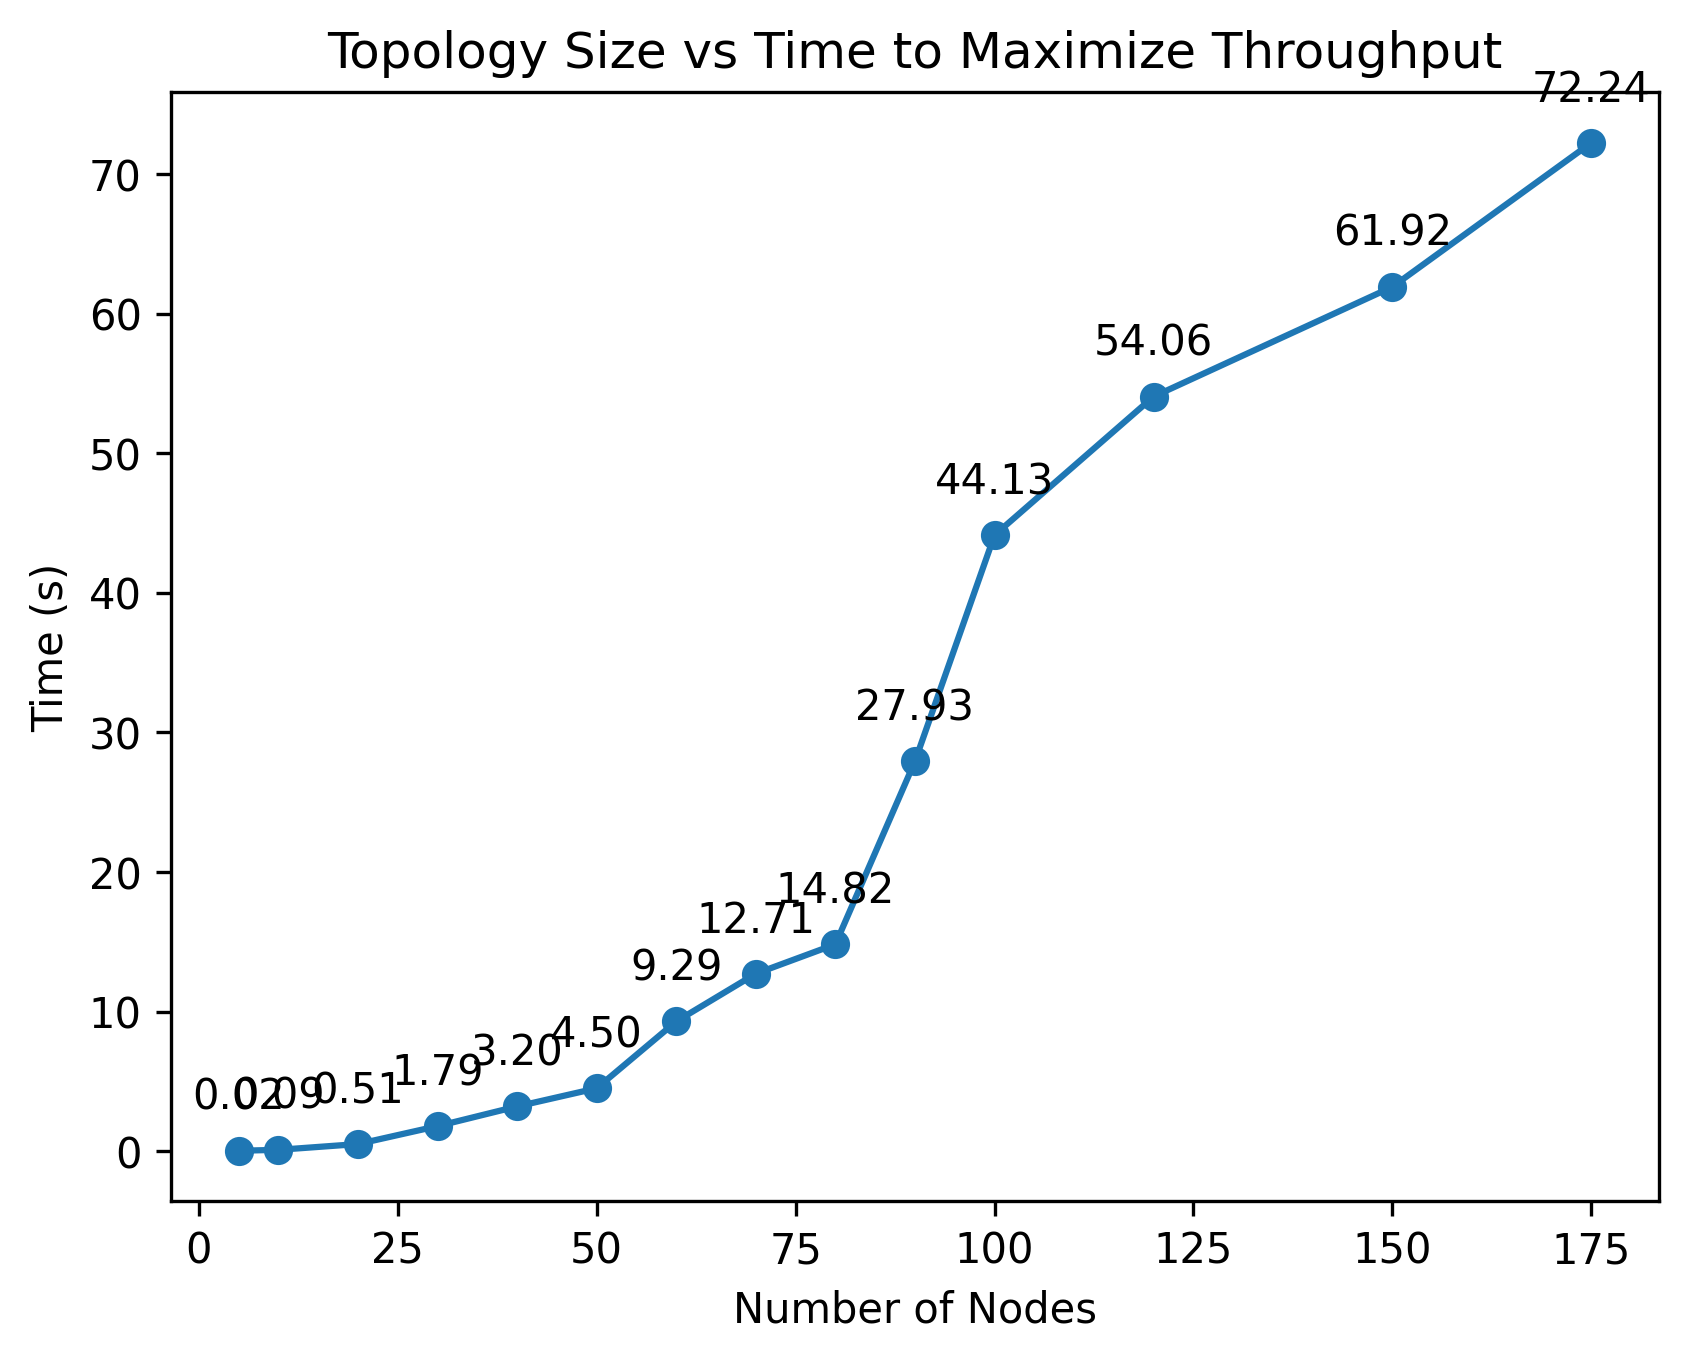

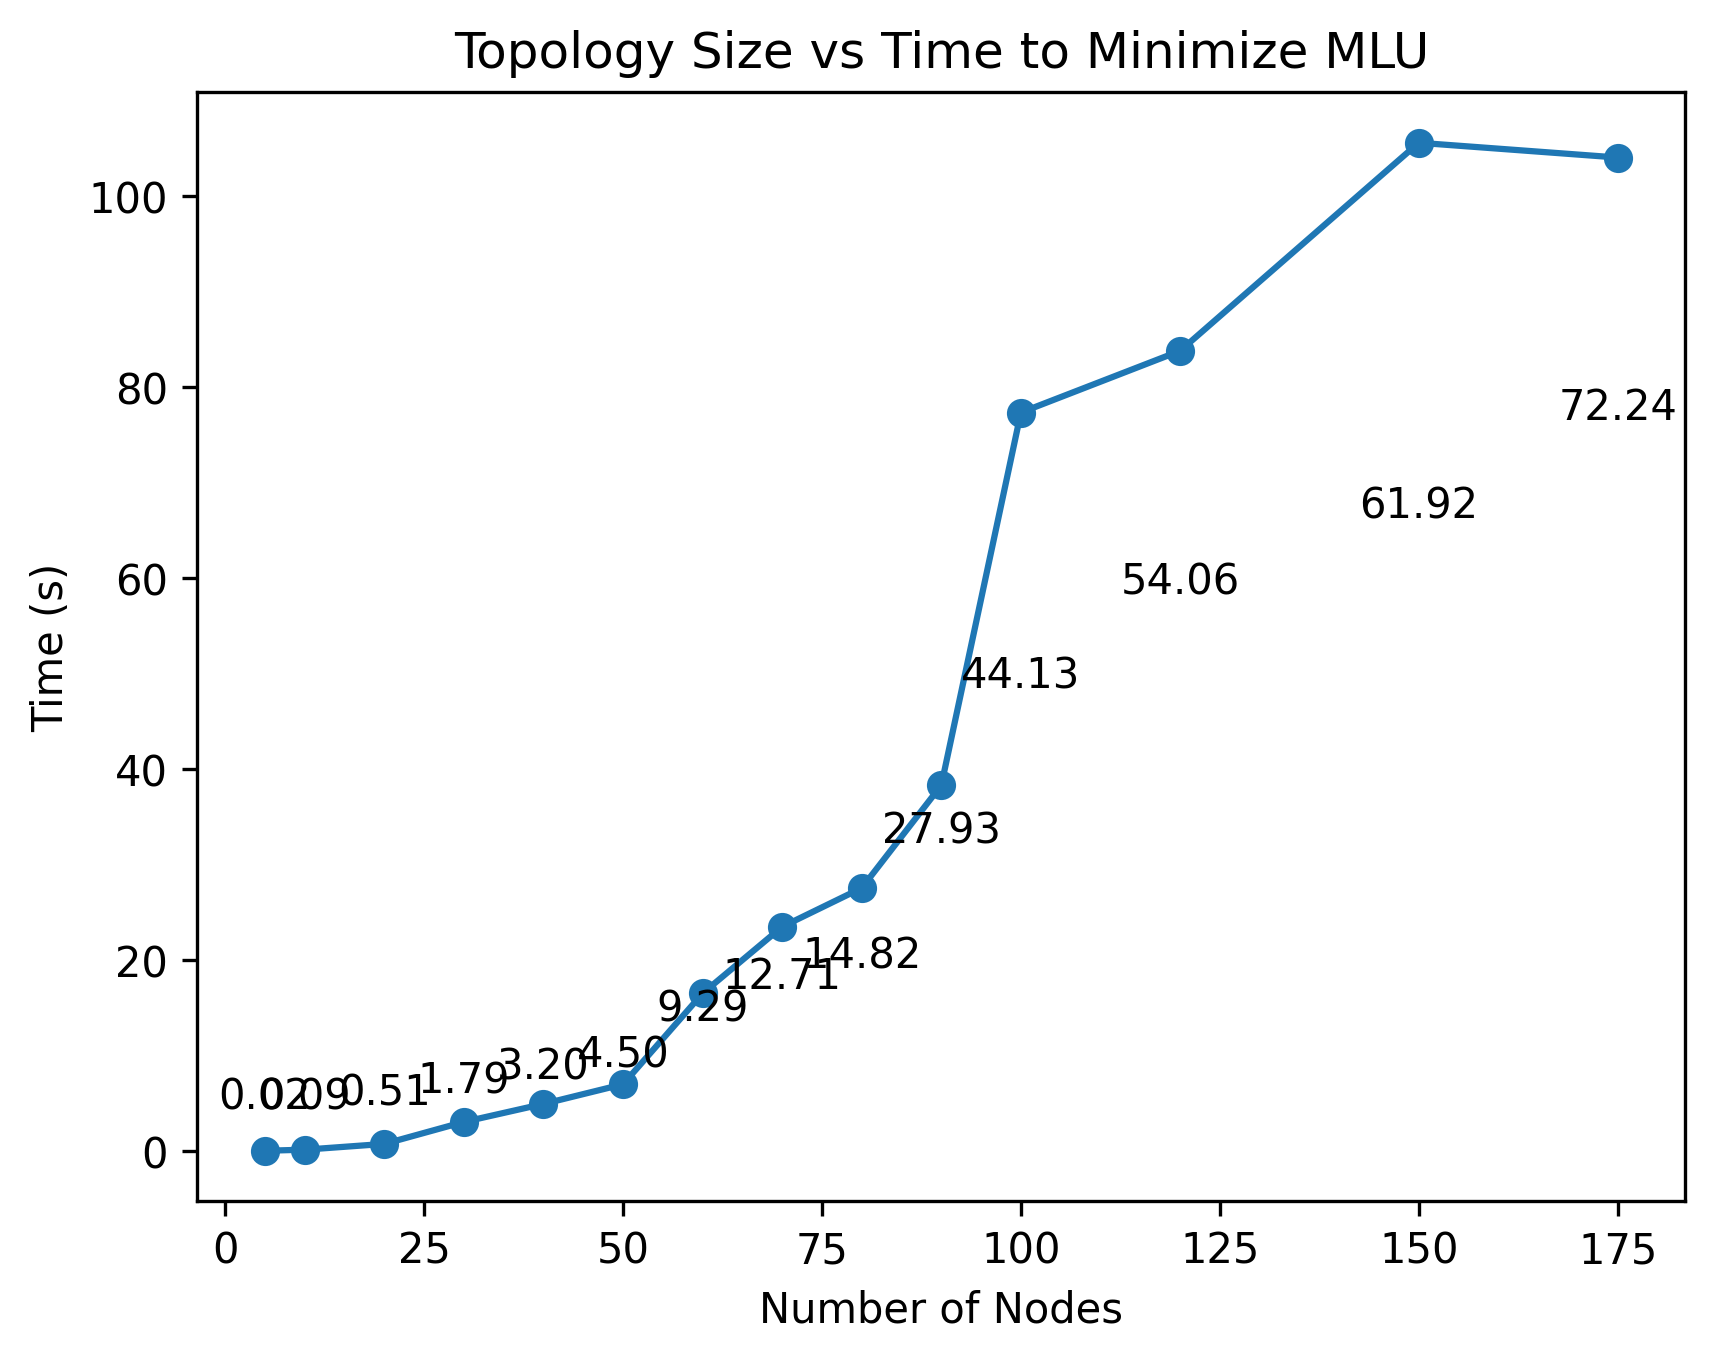

[0.023003339767456055, 0.09098410606384277, 0.5050079822540283, 1.7879972457885742, 3.1979942321777344, 4.499291896820068, 9.288976192474365, 12.711240291595459, 14.817201614379883, 27.93080234527588, 44.1285343170166, 54.06088590621948, 61.91876459121704, 72.24107456207275]
[0.04700016975402832, 0.16099882125854492, 0.7669997215270996, 3.0679845809936523, 4.953395128250122, 7.010068893432617, 16.535243034362793, 23.510035514831543, 27.568483352661133, 38.336915731430054, 77.36717867851257, 83.82273840904236, 105.62032175064087, 104.0745210647583]


In [56]:

#plt.yscale("log")
plt.plot(x_axis, y_axis_max, marker='o')
plt.title('Topology Size vs Time to Maximize Throughput')
plt.xlabel('Number of Nodes')
plt.ylabel('Time (s)')

#label points
for x,y in zip(x_axis, y_axis_max):
  label = "{:.2f}".format(y)
  plt.annotate(label, 
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center')
    
plt.show()

#plt.yscale("log")
plt.plot(x_axis, y_axis_min, marker = 'o')
plt.title('Topology Size vs Time to Minimize MLU')
plt.xlabel('Number of Nodes')
plt.ylabel('Time (s)')
for x,y in zip(x_axis, y_axis_max):
  label = "{:.2f}".format(y)
  plt.annotate(label, 
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center')
plt.show()

print(y_axis_max)
print(y_axis_min)